In [ ]:
"""File from Adam, used for correcting event mismatch and TIMESTEP MATCHING"""

'File from Adam, used for correcting event mismatch'

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import uproot
import pandas as pd
import awkward as ak
import re
from datetime import datetime, timedelta
import os

# this doesnt seem necessary and i cant find it anyways
#from tqdm.notebook import tqdm

from matplotlib.colors import LogNorm
import time

In [113]:
def baseline_subtract(trace):
    baseline = np.mean(trace[-100:])
    trace = trace.astype(float)
    trace -= baseline
    return trace

def delay_correct(trace, boardID):
    if (boardID<1) or (boardID>4):
        print("Bad BoardID")
        return False
    elif boardID!=1:
        return trace[24*(4-boardID):-24*(boardID-1)]
    else:
        return trace[24*3:]
    
def integrate_ROI_whole(trace):
    factor = 2000/(2**14 - 1)
    return -1*np.sum(trace)*factor*2/50

def integrate_ROI_majority(trace):
    factor = 2000/(2**14 - 1)
    return -1*np.sum(trace[160:230])*factor*2/50

def integrate_ROI_alpha(trace):
    factor = 2000/(2**14 - 1)
    return -1*np.sum(trace[320:390])*factor*2/50

def integrate_ROI_tp(trace):
    factor = 2000/(2**14 - 1)
    return -1*np.sum(trace[380:450])*factor*2/50

def integrate_ROI_v1740(trace):
    factor = 2000/(2**12 - 1)
    #return -1*np.sum(trace[340:370])*factor*2/50
    #return -1*np.sum(trace[350:450])*factor*2/50
    return -1*np.sum(trace)*factor*2/50

def get_calib(filename):
    df = pd.read_csv(filename)
    if len(df) != 58:
        print('Not all channels in calibration file!')
        #return None
    return df.set_index('ch_name')['spe_mean'].to_dict()

def get_height(trace):
    factor = 2000/(2**14 - 1)
    #return -1*np.min(trace[150:250])*factor
    return -1*np.min(trace[210:280])*factor

def get_height_alpha(trace):
    factor = 2000/(2**14 - 1)
    return -1*np.min(trace[90:120])*factor

def gaussian(x, mu, sigma, amplitude):
    return amplitude * np.exp(-(x - mu)**2 / (2 * sigma**2))

def fit(data, bins=100, range=(-10, 1000), window_size=10):
    # Step 1: Generate the histogram (frequency counts and bin edges)
    counts, bin_edges = np.histogram(data, bins=bins, range=range)
    
    # Step 2: Calculate bin centers (midpoints of each bin)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Step 3: Identify the peak bin (where counts are maximum)
    peak_index = np.argmax(counts)
    median = np.median(data)
    #peak_index = np.argmin(np.abs(bin_centers - median))
    peak_center = bin_centers[peak_index]
    
    # Step 4: Define the region around the peak to fit
    # Use a window size around the peak (e.g., 5 bins to the left and right)
    start_index = max(0, peak_index - window_size)
    end_index = min(len(bin_centers), peak_index + window_size)
    
    # Step 5: Fit the Gaussian to the selected region
    # Use the selected bin centers and counts around the peak
    selected_bin_centers = bin_centers[start_index:end_index]
    selected_counts = counts[start_index:end_index]
    
    # Initial guess for the parameters: mean (mu), standard deviation (sigma), and amplitude
    initial_guess = [peak_center, np.std(data), max(selected_counts)]
    
    # Fit the Gaussian to the selected region
    popt, _ = opt.curve_fit(gaussian, selected_bin_centers, selected_counts, p0=initial_guess, maxfev=10000)

    # Extract the parameters of the fitted Gaussian
    mu, sigma, amplitude = popt
    '''
    #Step 6: Plotting the histogram and the fitted Gaussian curve
    plt.hist(data, bins=bins, range=range, histtype='step', color='g', label='Histogram')
    
    # Generate a smooth range of x values for plotting the Gaussian
    plt.plot(selected_bin_centers, gaussian(selected_bin_centers, mu, sigma, amplitude), color='r', label='Fitted Gaussian')
    
    # Add labels and legend to the plot
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    
    # Show the plot
    plt.show()
    '''
    # Return histogram data and fitted Gaussian parameters (mu, sigma, amplitude)
    return mu, sigma, amplitude

def get_pe(traces, majority_ev, spe_means, event_ttt):
    tot_pe = np.zeros(len(traces['adc_b1_ch1']))
    side_pe = np.zeros(len(traces['adc_b1_ch1']))
    bot_pe = np.zeros(len(traces['adc_b1_ch1']))
    row1_pe = np.zeros(len(traces['adc_b1_ch1']))
    row2_pe = np.zeros(len(traces['adc_b1_ch1']))
    row3_pe = np.zeros(len(traces['adc_b1_ch1']))
    row4_pe = np.zeros(len(traces['adc_b1_ch1']))
    row5_pe = np.zeros(len(traces['adc_b1_ch1']))
    row6_pe = np.zeros(len(traces['adc_b1_ch1']))
    row7_pe = np.zeros(len(traces['adc_b1_ch1']))
    times = np.zeros(len(traces['adc_b1_ch1']))

    bad_chs = ['adc_b1_ch0', 'adc_b2_ch15', 'adc_b4_ch15', 'adc_b4_ch12', 'adc_b4_ch13', 'adc_b4_ch14', 'adc_b3_ch3', 'adc_b3_ch7']
    pattern1 = r'b(\d+)_ch(\d+)'
    pattern2 = r'b(\d+)_p(\d+)'
    for key in traces.keys():
        boardID = re.search(pattern1, key).group(1)
        boardID = int(boardID)
        if (boardID>4) or (key in bad_chs):
            continue
        chkey = chmap[key]
        for ev, trace in enumerate(traces[key]):
            if ev in majority_ev:
                if chkey=='bt_p1':
                    times[ev] += event_ttt[ev]*8e-9
                trace_sub = baseline_subtract(trace)
                trace_good = delay_correct(trace_sub, boardID)
                pulse = integrate_ROI_majority(trace_good)
                pulse_pe = pulse/spe_means[key]
                tot_pe[ev] += pulse_pe
                if ('bt' in chkey):
                    bot_pe[ev] += pulse_pe
                else:
                    side_pe[ev] += pulse_pe
                    column = re.search(pattern2, chkey).group(1)
                    row = re.search(pattern2, chkey).group(2)
                    column = int(column)
                    row = int(row)
                    if column<5:
                        if row==1:
                            row1_pe[ev] += pulse_pe
                        elif row==2:
                            row2_pe[ev] += pulse_pe
                        elif row==3:
                            row3_pe[ev] += pulse_pe
                        else:
                            row4_pe[ev] += pulse_pe
                    else:
                        if row==1:
                            row5_pe[ev] += pulse_pe
                        elif row==2:
                            row6_pe[ev] += pulse_pe
                        else:
                            row7_pe[ev] += pulse_pe
                      
    pes = {}
    pes['bottom'] = bot_pe
    pes['total'] = tot_pe
    pes['side'] = side_pe
    pes['row1'] = row1_pe
    pes['row2'] = row2_pe
    pes['row3'] = row3_pe 
    pes['row4'] = row4_pe
    pes['row5'] = row5_pe
    pes['row6'] = row6_pe
    pes['row7'] = row7_pe
    pes['times'] = times
    return pes

def get_majority(traces):
    trigtag_tpch = 'adc_b5_ch33'
    trigtag_alphach = 'adc_b5_ch34'
    trigtag_majoritych = 'adc_b5_ch35'
    trigtags = [trigtag_tpch, trigtag_alphach, trigtag_majoritych]

    tp_ev = []
    alpha_ev = []
    majority_ev = []

    for key in traces.keys():
        if key in trigtags:
            for ev, trace in enumerate(traces[key]):
                if np.min(trace) < 3000:
                    if key==trigtag_tpch:
                        tp_ev.append(ev)
                    elif key==trigtag_alphach:
                        alpha_ev.append(ev)
                    else:
                        majority_ev.append(ev)

    majority_ev = [ev for ev in majority_ev if ev not in tp_ev]
    alpha_ev = [ev for ev in alpha_ev if (ev not in tp_ev) and (ev not in majority_ev)]
    
    return majority_ev

def get_traces(fname):
    f = uproot.open(fname)
    daq = f['daq']
    traces = {}
    for key in daq.keys():
        if 'adc' in key:
            traces[key] = daq[key].array(library='np')
    event_ttt1 = daq['event_ttt_1'].array(library='np')
    event_ttt2 = daq['event_ttt_2'].array(library='np')
    event_ttt3 = daq['event_ttt_3'].array(library='np')
    event_ttt4 = daq['event_ttt_4'].array(library='np')
    event_id = daq['event_id'].array(library='np')
    #event_ttt = daq['event_ttt'].array(library='np')
    
    return traces, event_ttt1.astype(np.int64), event_ttt2.astype(np.int64), event_ttt3.astype(np.int64), event_ttt4.astype(np.int64), event_id

def get_1t_traces(fname):
    f = uproot.open(fname)
    daq = f['daq']
    traces = {}
    for key in daq.keys():
        if 'adc' in key:
            traces[key] = daq[key].array(library='np')
    event_ttt1 = daq['event_ttt_1'].array(library='np')
    event_ttt2 = daq['event_ttt_2'].array(library='np')
    event_ttt3 = daq['event_ttt_3'].array(library='np')
    event_ttt4 = daq['event_ttt_4'].array(library='np')
    event_ttt5 = daq['event_ttt_5'].array(library='np')
    event_id = daq['event_id'].array(library='np')
    event_sanity = daq['event_sanity'].array(library='np')
    #event_ttt = daq['event_ttt'].array(library='np')
    
    return traces, event_ttt1.astype(np.int64), event_ttt2.astype(np.int64), event_ttt3.astype(np.int64), event_ttt4.astype(np.int64), event_ttt5.astype(np.int64), event_id, event_sanity

In [114]:
#fname = '/media/disk_i/30t-DATA/raw_root/phase0/majority_test_250318T1047_75.root'
#fname = '/home/baldoni/drop/test/majority_test_250208T1252_1.root'
#fname = '/home/baldoni/drop/test/majority_test_250310T1145_70.root'
#fname = '/home/baldoni/drop/test/majority_test_250318T1047_75.root'
fname = '/home/baldoni/drop/test/majority_test_250320T1525_57.root'
traces, event_ttt1, event_ttt2, event_ttt3, event_ttt4, event_id = get_traces(fname)

In [115]:
diff21 = event_ttt2 - event_ttt1
diff31 = event_ttt3 - event_ttt1
diff41 = event_ttt4 - event_ttt1
print(diff21[:10])
print(diff31[:10])
print(diff41[:10])

[6 6 6 6 6 6 6 6 6 6]
[12 12 12 12 12 12 12 12 12 12]
[-102 -102 -102 -102 -102 -102 -102 -102 -102 -102]


In [116]:
print(event_ttt4[0])
print(event_ttt1[0])

6910370834377
6910370834479


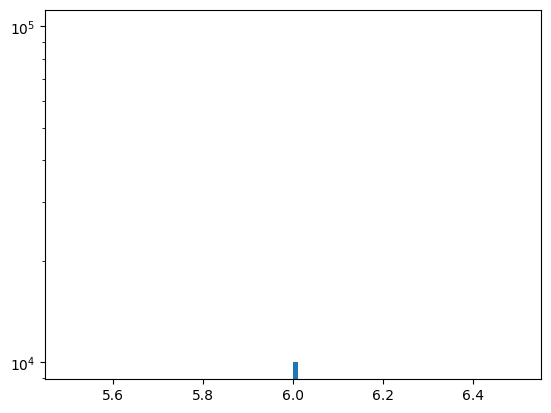

In [117]:
plt.hist(diff21, bins=100)
plt.yscale('log')
#print(len([np.argwhere(val) for val in diff21 if val>8]))

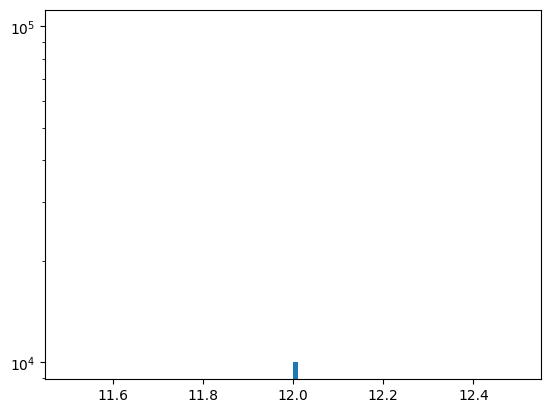

In [118]:
plt.hist(diff31, bins=100)
plt.yscale('log')

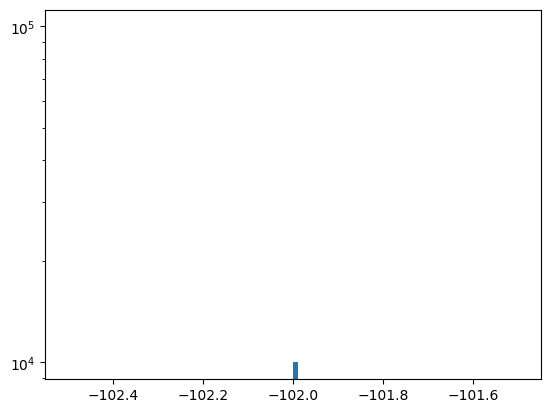

In [119]:
plt.hist(diff41, bins=100)
plt.yscale('log')

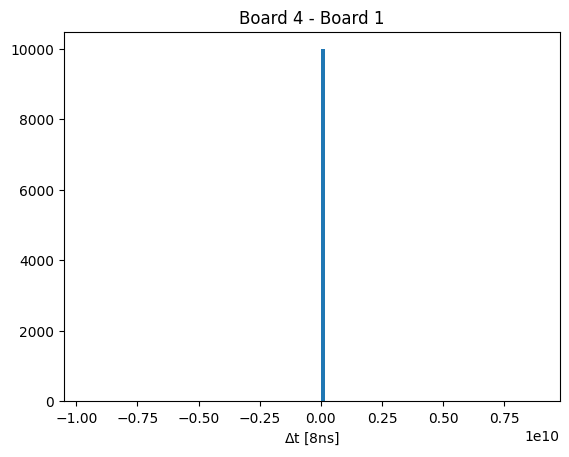

0.0


In [120]:
diffs_test = event_ttt4[1:] - event_ttt1[:-1]
#plt.hist(diffs_test, bins=100, range=(-17, -13))
plt.hist(diffs_test, bins=100)
#plt.hist(diff51, bins=100)
#plt.yscale('log')
plt.title('Board 4 - Board 1')
plt.xlabel(r'$\Delta$t [8ns]')
#plt.xlim(-20, 20)
#plt.hlines(5e3, -100, 100, 'r')
plt.show()
print(len([diff for diff in diffs_test if -17<diff and diff<-13])/len(diffs_test))

In [1]:
plt.plot(event_ttt1)
#plt.plot(event_ttt2)
#plt.plot(event_ttt3)
plt.plot(event_ttt4)
#plt.plot(event_ttt5[:10])
plt.show()

NameError: name 'plt' is not defined

In [122]:
# broken code
# weird = event_id[np.array([np.argwhere(val)[0] for val in diff21 if val>8])]
# print([np.argwhere(val) for val in diff21 if val>8])

In [123]:
# print(len(weird))
# weird[0]

In [124]:
for i in range(len(diff21)):
    if diff21[i]>8:
        print(i)

In [125]:
print(event_id[3381])

573071


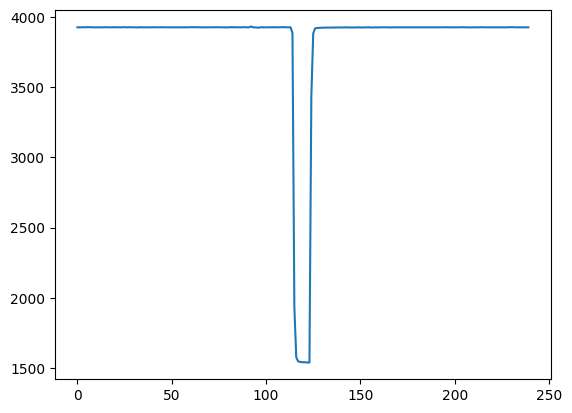

In [126]:
plt.plot(traces['adc_b4_ch22'][644]);

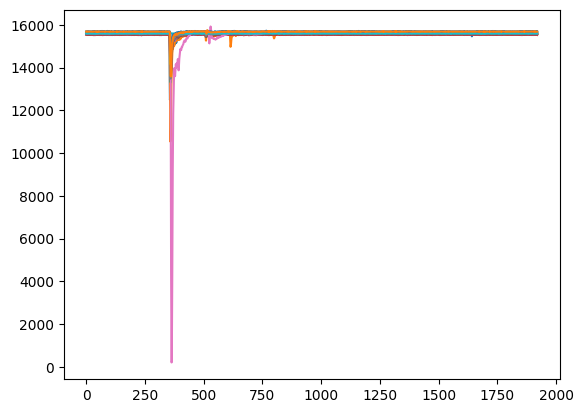

In [127]:
for i in range(12):
    ch = 'adc_b1_ch'+str(i)
    plt.plot(traces[ch][644], label=ch)
plt.show()

In [128]:
print(event_ttt1[3381], event_ttt2[3381])

6946596154915 6946596154921


In [129]:
print(event_id[644])

570701


In [130]:
print(diff21[338])

6


In [131]:
event_ttt1

array([6910370834479, 6910371538957, 6910388784017, ..., 7030246537123,
       7030326368097, 7030347503601], shape=(10001,))

In [132]:
len(str(2**64))

20

In [133]:
#fname = '/media/disk_k/WbLS-DATA/raw_root/phase8/muon/muon_wbls07_250310T1046_99.root'
#fname = '/media/disk_k/WbLS-DATA/raw_root/phase9/muon/muon_wbls1pct_250311T1511_12.root'
fname = '/media/disk_k/WbLS-DATA/raw_root/phase9/muon/muon_wbls1pct_250319T1000_120.root'
traces, event_ttt1, event_ttt2, event_ttt3, event_ttt4, event_ttt5, event_id, event_sanity = get_1t_traces(fname)

In [134]:
diff21 = event_ttt2 - event_ttt1
diff31 = event_ttt3 - event_ttt1
diff41 = event_ttt4 - event_ttt1
diff51 = event_ttt5 - event_ttt1
print(diff21[:10])
print(diff31[:10])
print(diff41[:10])
print(diff51[:10])

[6 6 6 6 6 6 6 6 6 6]
[12 12 12 12 12 12 12 12 12 12]
[18 18 18 18 18 18 18 18 18 18]
[26 26 24 26 24 26 24 24 24 26]


In [135]:
print(event_ttt1[2361:2363], event_ttt2[2362])

[10310754227883 10310758631819] 10310758631825


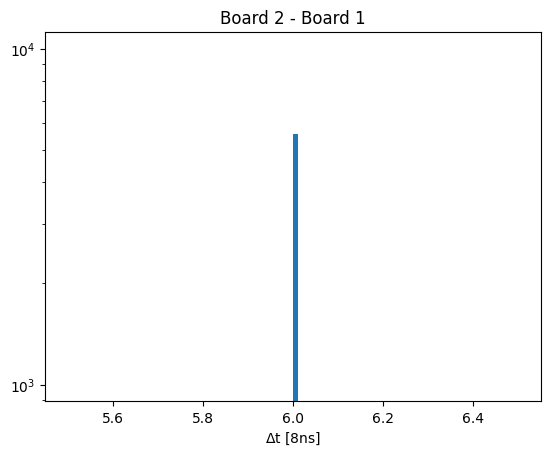

6
6


In [136]:
plt.hist(diff21, bins=100)
plt.yscale('log')
plt.title('Board 2 - Board 1')
plt.xlabel(r'$\Delta$t [8ns]')
plt.show()

print(min(diff21))
print(max(diff21))

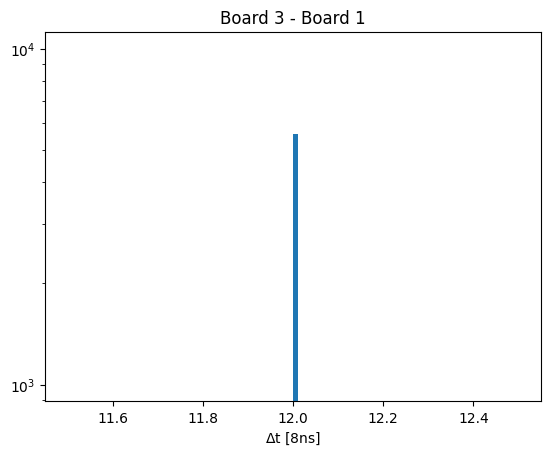

In [137]:
plt.hist(diff31, bins=100)
plt.yscale('log')
plt.title('Board 3 - Board 1')
plt.xlabel(r'$\Delta$t [8ns]')
plt.show()

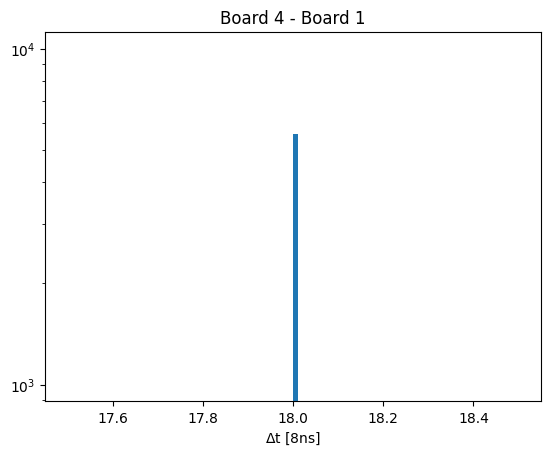

In [138]:
plt.hist(diff41, bins=100)
plt.yscale('log')
plt.title('Board 4 - Board 1')
plt.xlabel(r'$\Delta$t [8ns]')
plt.show()

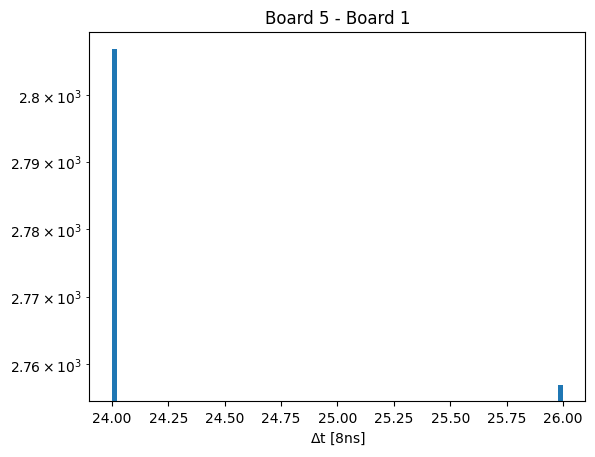

In [139]:
plt.hist(diff51, bins=100)
plt.yscale('log')
plt.title('Board 5 - Board 1')
plt.xlabel(r'$\Delta$t [8ns]')
plt.show()

[10297728232685 10297749812845 10297752885045 10297758576515
 10297768027951 10297775606589 10297794638327 10297799070957
 10297803626479 10297812201977 10297815855551 10297842309089
 10297847286399 10297859662427 10297864301655 10297874349599
 10297896779649 10297902105073 10297902234639 10297907055847
 10297909937675 10297914331107 10297936218471 10297941670951
 10297943521053 10297946216177 10297952534847 10297960367455
 10297982741905 10297988350789]
0.09593633600000001
0.060629104


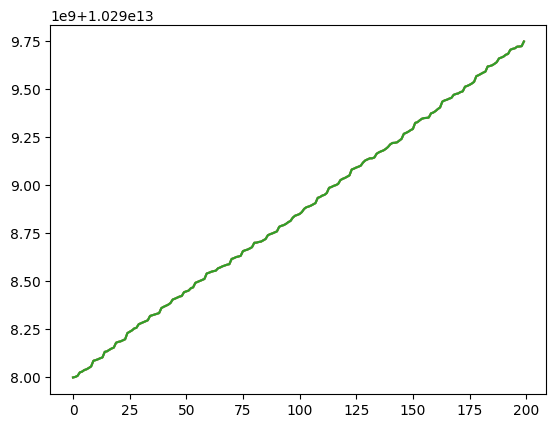

In [140]:
#plt.plot(event_ttt4[500:700]);
#plt.plot(event_ttt1[500:700])
plt.plot(event_ttt2[500:700]);
plt.plot(event_ttt3[500:700])
plt.plot(event_ttt5[500:700])
print(event_ttt4[470:500])
print((event_ttt4[302] - event_ttt4[301])*8e-9)
print((event_ttt4[475] - event_ttt4[474])*8e-9)

In [2]:
plt.plot(event_ttt1)
plt.plot(event_ttt2)
plt.plot(event_ttt3)
plt.plot(event_ttt4)
plt.plot(event_ttt5[:10])
plt.show()

NameError: name 'plt' is not defined

In [142]:
print(event_ttt5[1] - event_ttt5[0])

3552764


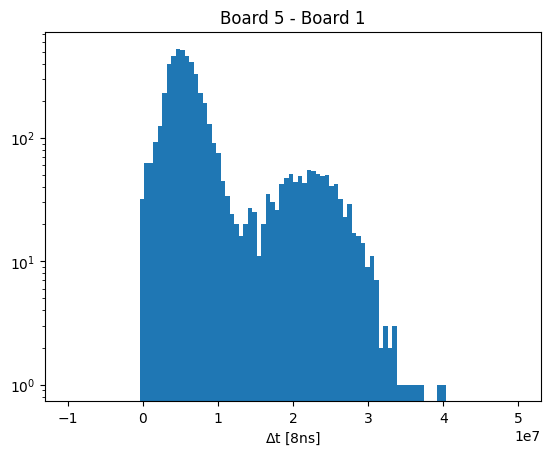

0.0


In [143]:
diffs_test = event_ttt5[1:] - event_ttt1[:-1]
#plt.hist(diffs_test, bins=100, range=(-17, -13))
plt.hist(diffs_test, bins=100, range=(-1e7, 5e7))
#plt.hist(diff51, bins=100)
plt.yscale('log')
plt.title('Board 5 - Board 1')
plt.xlabel(r'$\Delta$t [8ns]')
#plt.xlim(-20, 20)
#plt.hlines(5e3, -100, 100, 'r')
plt.show()
print(len([diff for diff in diffs_test if -17<diff and diff<-13])/len(diffs_test))

In [144]:
print(min(event_ttt1))

10293652138441


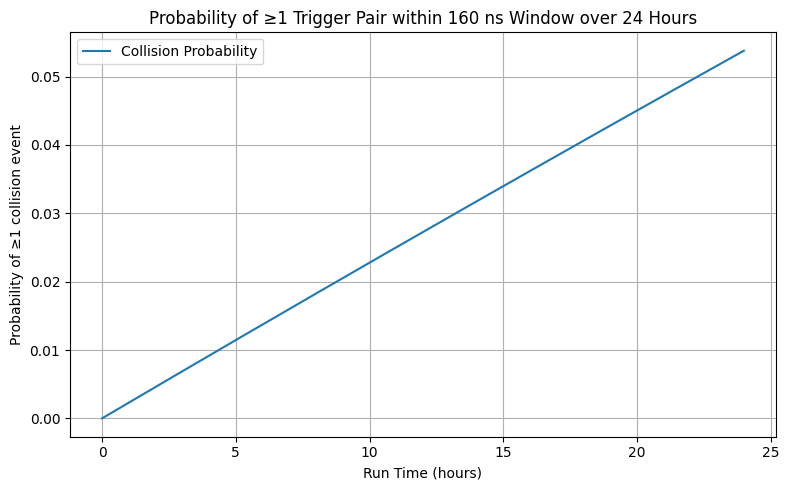

In [145]:
import numpy as np
import matplotlib.pyplot as plt

def collision_probability(t_hours, rate=2.0, delta_t=160e-9):
    """
    Probability of at least one collision occurring within [0, t_hours].

    Parameters:
    -----------
    t_hours : float or np.array
        Time in hours.
    rate : float
        Trigger rate in Hz.
    delta_t : float
        Critical time window in seconds.

    Returns:
    --------
    float or np.array
        Probability of at least one collision event.
    """
    t_seconds = t_hours * 3600  # Convert hours to seconds
    p = rate * delta_t
    n_triggers = rate * t_seconds
    return 1.0 - np.exp(-p * n_triggers)

# Time array from 0 to 24 hours
time_hours = np.linspace(0, 24, 2000)

# Calculate probability
probability = collision_probability(time_hours)

# Plotting the results
plt.figure(figsize=(8,5))
plt.plot(time_hours, probability, label="Collision Probability")
plt.xlabel("Run Time (hours)")
plt.ylabel("Probability of ≥1 collision event")
plt.title("Probability of ≥1 Trigger Pair within 160 ns Window over 24 Hours")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

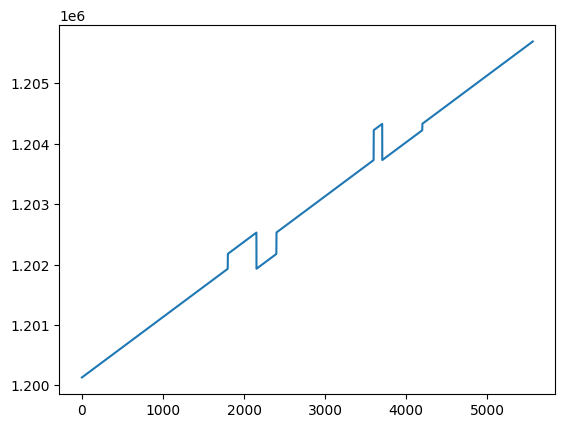

In [146]:
plt.plot(event_id);

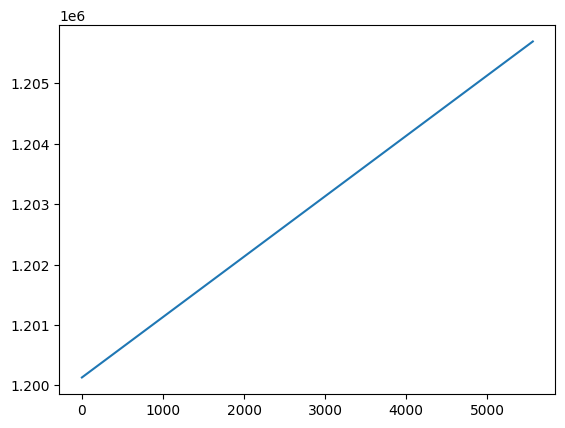

In [147]:
array_idx = sorted(range(len(event_id)), key=lambda i: event_id[i])
plt.plot(event_id[array_idx]);

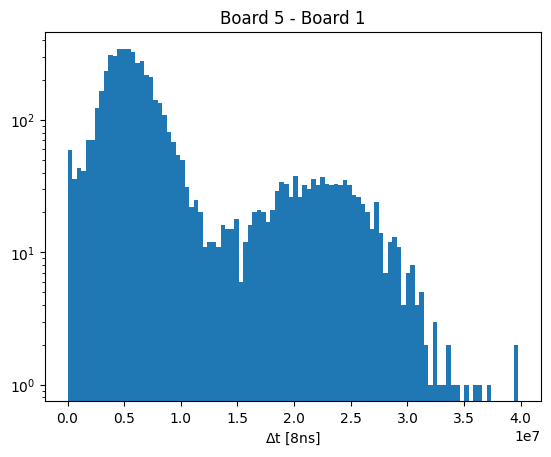

0.0


In [148]:
event_ttt5_good = event_ttt5[array_idx]
event_ttt1_good = event_ttt1[array_idx]
diffs_good = event_ttt5_good[1:] - event_ttt1_good[:-1]
plt.hist(diffs_good, bins=100)
plt.yscale('log')
plt.title('Board 5 - Board 1')
plt.xlabel(r'$\Delta$t [8ns]')
plt.show()
print(len([diff for diff in diffs_good if -17<diff and diff<-13])/len(diffs_good))

In [149]:

%%time
# Example arrays (time arrays)
#array1 = np.array([1.0, 2.0, 3.0, 4.0])  # First array of event times
#array2 = np.array([1.1, 2.05, 2.9, 4.2, 5.5, 6.1, 7.0])  # Second array of event times (mismatched)
array2 = event_ttt5_good
array1 = event_ttt1_good

# Maximum window size for local search
window_size = 3

# Array to store the closest elements from array2 for each element in array1
array2_idx = []
array1_idx = []

# For each element in array1, find the closest element in array2 within the window size
for i, val1 in enumerate(array1):
    # Define the search window (max 5 elements before and after in array2)
    start_idx = max(i - window_size, 0)
    end_idx = min(i + window_size + 1, len(array2))
    
    # Find the index of the closest element in array2 within the window
    local_window = array2[start_idx:end_idx]
    closest_idx = np.argmin(np.abs(local_window - val1)) + start_idx  # Add start_idx to get global index
    
    if -17 < (array2[closest_idx ] - val1) < -13:
        array1_idx.append(i)
        array2_idx.append(closest_idx)

    # Append the closest element from array2 to matched_array2
    #matched_array2.append(array2[closest_idx])

# Convert matched_array2 to a numpy array for easy use
#matched_array2 = np.array(matched_array2)

#print("Matched elements in array2:", matched_array2)


CPU times: user 12.8 ms, sys: 841 μs, total: 13.6 ms
Wall time: 12.5 ms


In [150]:
event_ttt5_final = event_ttt5_good[array2_idx]
event_ttt1_final = event_ttt1_good[array1_idx]

/tmp/ipykernel_629691/3698895538.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


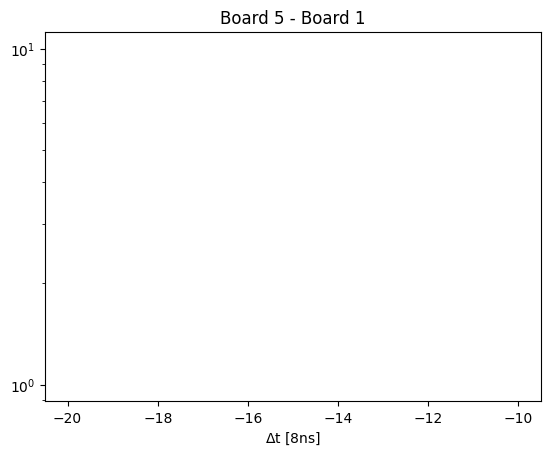

In [151]:
diffs_test1 = event_ttt5_final - event_ttt1_final
plt.hist(diffs_test1, bins=100, range=(-20, -10))
plt.yscale('log')
plt.title('Board 5 - Board 1')
plt.xlabel(r'$\Delta$t [8ns]')
plt.show()
#print(len([diff for diff in diffs_test1 if -17<diff and diff<-13])/len(diffs_test1))

In [152]:
array1_final = np.array(array_idx)[array1_idx]
array2_final = np.array(array_idx)[array2_idx]

/tmp/ipykernel_629691/9479234.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


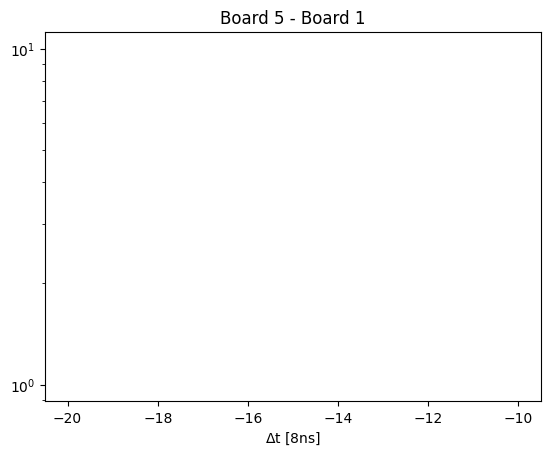

In [153]:
diffs_test2 = event_ttt5[array2_final] - event_ttt1[array1_final]
plt.hist(diffs_test2, bins=100, range=(-20, -10))
plt.yscale('log')
plt.title('Board 5 - Board 1')
plt.xlabel(r'$\Delta$t [8ns]')
plt.show()
#print(len([diff for diff in diffs_test2 if -17<diff and diff<-13])/len(diffs_test2))
#print(len(diffs_test2)/len(diff51))

In [154]:
#output_file = uproot.recreate("corrected_file.root")
'''
for key, obj in uproot.open(fname).items():
    if key=="daq":
        new_daq = obj.copy()
        for key1, obj1 in new_daq:
            if "adc_b5" in key1:
                obj1 = traces[key1][array2_final]
            elif "adc" in key1:
                obj1 = traces[key1][array1_final]
        new_daq["event_ttt5"] = event_ttt5[array2_final]
        new_daq["event_ttt4"] = event_ttt4[array1_final]
        new_daq["event_ttt3"] = event_ttt3[array1_final]
        new_daq["event_ttt2"] = event_ttt2[array1_final]
        new_daq["event_ttt1"] = event_ttt1[array1_final]
        new_daq["event_id"] = event_id[array1_final]
        new_daq["event_sanity"] = event_sanity[array1_final]
        
        output_file[key] = new_daq
    else:
        1 + 1
        #output_file[key] = obj
'''
new_daq = {}
for key in daq.keys():
    if "adc_b5" in key:
        new_daq[key] = traces[key][array2_final]
    elif "adc" in key:
        new_daq[key] = traces[key][array1_final]
new_daq["event_ttt5"] = event_ttt5[array2_final]
new_daq["event_ttt4"] = event_ttt4[array1_final]
new_daq["event_ttt3"] = event_ttt3[array1_final]
new_daq["event_ttt2"] = event_ttt2[array1_final]
new_daq["event_ttt1"] = event_ttt1[array1_final]
new_daq["event_id"] = event_id[array1_final]
new_daq["event_sanity"] = event_sanity[array1_final]

output_file = uproot.recreate("corrected_file.root")
output_file['daq'] = {branch: new_daq[branch] for branch in new_daq}

data = run_info.arrays(library='np')
output_file['run_info'] = {branch: data[branch] for branch in data}
output_file.close()

NameError: name 'daq' is not defined

In [ ]:
f = uproot.open(fname)
daq = f["daq"]
for key, obj in daq.items():
    print(key, obj.interpretation)
    
run_info = f['run_info']

adc_b5_ch38 AsDtype("('>u2', (240,))")
adc_b5_ch8 AsDtype("('>u2', (240,))")
adc_b1_ch14 AsDtype("('>u2', (2000,))")
adc_b1_ch15 AsDtype("('>u2', (2000,))")
adc_b1_ch3 AsDtype("('>u2', (2000,))")
adc_b5_ch25 AsDtype("('>u2', (240,))")
adc_b3_ch11 AsDtype("('>u2', (2000,))")
adc_b5_ch31 AsDtype("('>u2', (240,))")
adc_b4_ch3 AsDtype("('>u2', (2000,))")
adc_b4_ch0 AsDtype("('>u2', (2000,))")
adc_b3_ch6 AsDtype("('>u2', (2000,))")
adc_b5_ch1 AsDtype("('>u2', (240,))")
adc_b5_ch13 AsDtype("('>u2', (240,))")
adc_b5_ch9 AsDtype("('>u2', (240,))")
adc_b2_ch5 AsDtype("('>u2', (2000,))")
adc_b5_ch14 AsDtype("('>u2', (240,))")
adc_b5_ch29 AsDtype("('>u2', (240,))")
adc_b5_ch30 AsDtype("('>u2', (240,))")
adc_b1_ch5 AsDtype("('>u2', (2000,))")
adc_b4_ch6 AsDtype("('>u2', (2000,))")
adc_b1_ch0 AsDtype("('>u2', (2000,))")
adc_b3_ch9 AsDtype("('>u2', (2000,))")
adc_b3_ch15 AsDtype("('>u2', (2000,))")
adc_b3_ch14 AsDtype("('>u2', (2000,))")
adc_b3_ch2 AsDtype("('>u2', (2000,))")
adc_b3_ch10 AsDtype("('

In [ ]:
def get_1t_info(fname):
    f = uproot.open(fname)
    daq = f['daq']
    run_info = f['run_info']
    daqkeys = daq.keys()
    traces = {}
    for key in daq.keys():
        if 'adc' in key:
            traces[key] = daq[key].array(library='np')
    event_ttt1 = daq['event_ttt_1'].array(library='np')
    event_ttt2 = daq['event_ttt_2'].array(library='np')
    event_ttt3 = daq['event_ttt_3'].array(library='np')
    event_ttt4 = daq['event_ttt_4'].array(library='np')
    event_ttt5 = daq['event_ttt_5'].array(library='np')
    event_id = daq['event_id'].array(library='np')
    event_sanity = daq['event_sanity'].array(library='np')
    #event_ttt = daq['event_ttt'].array(library='np')
    
    return traces, event_ttt1.astype(np.int64), event_ttt2.astype(np.int64), event_ttt3.astype(np.int64), event_ttt4.astype(np.int64), event_ttt5.astype(np.int64), event_id, event_sanity, daqkeys, run_info

def correct_times(event_ttt1, event_ttt5, event_id):
    array_idx = sorted(range(len(event_id)), key=lambda i: event_id[i])
    
    event_ttt5_good = event_ttt5[array_idx]
    event_ttt1_good = event_ttt1[array_idx]
    
    event_ttt5_good_idx = []
    event_ttt1_good_idx = []
    
    window_size = 3
    
    for i, val1 in enumerate(event_ttt1_good):
        # Define the search window (max 3 elements before and after in event_ttt5_good)
        start_idx = max(i - window_size, 0)
        end_idx = min(i + window_size + 1, len(event_ttt5_good))

        # Find the index of the closest element in event_ttt5_good within the window
        local_window = event_ttt5_good[start_idx:end_idx]
        closest_idx = np.argmin(np.abs(local_window - val1)) + start_idx  # Add start_idx to get global index

        if -17 < (event_ttt5_good[closest_idx ] - val1) < -13:
            event_ttt1_good_idx.append(i)
            event_ttt5_good_idx.append(closest_idx)
            
    event_ttt1_good_final = np.array(array_idx)[event_ttt1_good_idx]
    event_ttt5_good_final = np.array(array_idx)[event_ttt5_good_idx]
    
    return event_ttt1_good_final, event_ttt5_good_final

def write_corrected_root(outfname, traces, event_ttt1, event_ttt2, event_ttt3, event_ttt4, event_ttt5, event_id, event_sanity, daqkeys, run_info, event_ttt1_good_final, event_ttt5_good_final):
    
    new_daq = {}
    for key in daqkeys:
        if "adc_b5" in key:
            new_daq[key] = traces[key][event_ttt5_good_final]
        elif "adc" in key:
            new_daq[key] = traces[key][event_ttt1_good_final]
    new_daq["event_ttt5"] = event_ttt5[event_ttt5_good_final]
    new_daq["event_ttt4"] = event_ttt4[event_ttt1_good_final]
    new_daq["event_ttt3"] = event_ttt3[event_ttt1_good_final]
    new_daq["event_ttt2"] = event_ttt2[event_ttt1_good_final]
    new_daq["event_ttt1"] = event_ttt1[event_ttt1_good_final]
    new_daq["event_id"] = event_id[event_ttt1_good_final]
    new_daq["event_sanity"] = event_sanity[event_ttt1_good_final]

    output_file = uproot.recreate("corrected_file.root")
    output_file['daq'] = {branch: new_daq[branch] for branch in new_daq}

    data = run_info.arrays(library='np')
    output_file['run_info'] = {branch: data[branch] for branch in data}
    output_file.close()

In [ ]:
%%time

fname = '/media/disk_k/WbLS-DATA/raw_root/phase9/muon/muon_wbls1pct_250311T1511_12.root'
traces, event_ttt1, event_ttt2, event_ttt3, event_ttt4, event_ttt5, event_id, event_sanity, daqkeys, run_info = get_1t_info(fname)
array1_final, array2_final = correct_times(event_ttt1, event_ttt2, event_id)
outfname = "corrected_file.root"
write_corrected_root(outfname, traces, event_ttt1, event_ttt2, event_ttt3, event_ttt4, event_ttt5, event_id, event_sanity, daqkeys, 
, array1_final, array2_final)

CPU times: user 23.2 s, sys: 13.6 s, total: 36.8 s
Wall time: 36.8 s


In [ ]:
fname = 'corrected_file.root'
f = uproot.open(fname)
daq = f['daq']
event_ttt1 = daq['event_ttt1'].array(library='np')
event_ttt5 = daq['event_ttt5'].array(library='np')
diffs = event_ttt5 - event_ttt1

9730

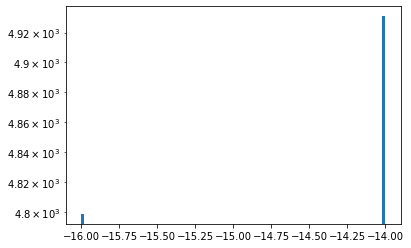

In [ ]:
plt.hist(diffs, bins=100)
plt.yscale('log')
plt.show()